In [1]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
import os, torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from torch import nn
from aae import SemiSupervisedAutoEncoderOptions, SemiSupervisedAdversarialAutoencoder

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
print("Built with CUDA:", torch.version.cuda)     
print("CUDA available?:", torch.cuda.is_available())  
print("Device count:", torch.cuda.device_count())

CUDA_VISIBLE_DEVICES: 0
Built with CUDA: 12.6
CUDA available?: True
Device count: 1


#### Helper for data loading

In [4]:
class UnlabeledWrapper(Dataset):
    """Return images only; label is always -1."""
    def __init__(self, base_ds, indices):
        self.base_ds = base_ds
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        x, _ = self.base_ds[self.indices[i]]
        return x, -1


def configure_mnist(batch_size=100, n_labeled=1000, val_fraction=0.10, seed=42):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))          # flatten to 784
    ])

    full_train = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
    test_ds    = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    rng = np.random.RandomState(seed)
    all_idx       = np.arange(len(full_train))                       # 60 000 indices
    labeled_idx   = rng.choice(all_idx, size=n_labeled, replace=False)
    remaining_idx = np.setdiff1d(all_idx, labeled_idx)

    n_val   = int(len(remaining_idx) * val_fraction)
    val_idx = rng.choice(remaining_idx, size=n_val, replace=False)
    unlabeled_idx = np.setdiff1d(remaining_idx, val_idx)

    labeled_ds     = Subset(full_train, labeled_idx)                 # (x, y)
    val_ds         = Subset(full_train, val_idx)                     # (x, y)
    unlabeled_ds   = UnlabeledWrapper(full_train, unlabeled_idx)     # (x, -1)

    train_labeled_loader   = DataLoader(labeled_ds,   batch_size=batch_size, shuffle=True,  drop_last=True)
    train_unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader             = DataLoader(val_ds,       batch_size=batch_size, shuffle=False)
    test_loader            = DataLoader(test_ds,      batch_size=batch_size, shuffle=False)

    X_lab = torch.stack([x for x, _ in labeled_ds])
    Y_lab = torch.tensor([y for _, y in labeled_ds])

    X_val = torch.stack([x for x, _ in val_ds])
    Y_val = torch.tensor([y for _, y in val_ds])

    X_test = torch.stack([x for x, _ in test_ds])
    Y_test = test_ds.targets.clone()

    return (X_lab, X_val, X_test,
            Y_lab, Y_val, Y_test,
            train_labeled_loader, train_unlabeled_loader, val_loader, test_loader)

## 1) Training

Below you can set up any hyperparameters for the experiment

In [4]:
NUM_EPOCHS = 2000
GAUSSIAN_NOISE = True
INPUT_DIM = 784
BATCH_SIZE = 100
AE_HIDDEN = 1000
DC_HIDDEN = 1000
LATENT_DIM_CAT = 10
LATENT_DIM_STYLE = 10
PRIOR_STD = 1.0
RESULT_FOLDER = 'results_2000_epochs_2000_samples'
NUM_LABELED = 2000

recon_loss = nn.MSELoss()
init_recon_lr = 0.001

semi_sup_loss = nn.CrossEntropyLoss()
init_semi_sup_lr = 0.001

init_gen_lr = init_disc_lr = 0.001
use_decoder_sigmoid = True

Preparing the data laoders. This includes a labeled training data laoder, unlabeled training data loader, as well as data laoders for valiudation and testing

In [6]:
(X_lab, X_val, X_test,
 Y_lab, Y_val, Y_test,
 train_labeled_loader,
 train_unlabeled_loader,
 val_loader,
 test_loader) = configure_mnist(batch_size=BATCH_SIZE, n_labeled=NUM_LABELED)

print("labelled   :", len(train_labeled_loader.dataset))   # 1 000
print("unlabelled :", len(train_unlabeled_loader.dataset)) # ≈53 000
print("val        :", len(val_loader.dataset))             # ≈6 000
print(Y_lab.max(), Y_lab.min())      

labelled   : 2000
unlabelled : 52200
val        : 5800
tensor(9) tensor(0)


Initializing the model

In [5]:
options = SemiSupervisedAutoEncoderOptions(
    input_dim=INPUT_DIM,
    ae_hidden_dim=AE_HIDDEN,
    disc_hidden_dim=DC_HIDDEN,
    latent_dim_categorical=LATENT_DIM_CAT,
    latent_dim_style=LATENT_DIM_STYLE,
    recon_loss_fn=recon_loss,
    init_recon_lr=init_recon_lr,
    semi_supervised_loss_fn=semi_sup_loss,
    init_semi_sup_lr=init_semi_sup_lr,
    init_gen_lr=init_gen_lr,
    use_decoder_sigmoid=use_decoder_sigmoid,
    init_disc_categorical_lr = init_disc_lr,
    init_disc_style_lr = init_disc_lr
)

model = SemiSupervisedAdversarialAutoencoder(options);

Run the training, weighst get saved automatically

In [ ]:
model.train_mbgd(
    val_loader=val_loader,
    epochs=NUM_EPOCHS,
    prior_std=PRIOR_STD,
    result_folder=RESULT_FOLDER,
    add_gaussian_noise=GAUSSIAN_NOISE,
    train_labeled_loader=train_labeled_loader,
    train_unlabeled_loader=train_unlabeled_loader,
    save_interval=500
)

## 2) Evaluation

You can load the weights from any previous run

In [6]:
model.load_weights("results_2000_epochs_2000_samples/weights")

Weights loaded from results_2000_epochs_2000_samples/weights_*.pth


#### Evaluating classifcation accuracy of the encoder

In [ ]:
all_probs, all_preds = [], []
for imgs, _ in test_loader:
    probs, preds = model.predict(imgs)
    all_probs.append(probs.cpu())
    all_preds.append(preds.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)

In [ ]:
num_correct = torch.eq(all_preds, Y_test).sum().item()
accuracy = num_correct / Y_test.size(0)
print(f"Test accuracy: {accuracy*100:.2f}%")

#### Image generation

Genrate a single image of a digit

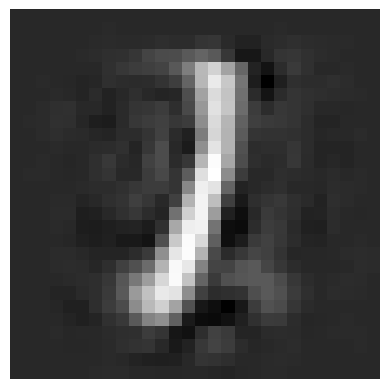

In [8]:
import matplotlib.pyplot as plt

img7 = model.generate_images(1, prior_std=1.0)
plt.imshow(img7.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

Generate digits from 0 to 9 with random style code sampled froma  gaussian

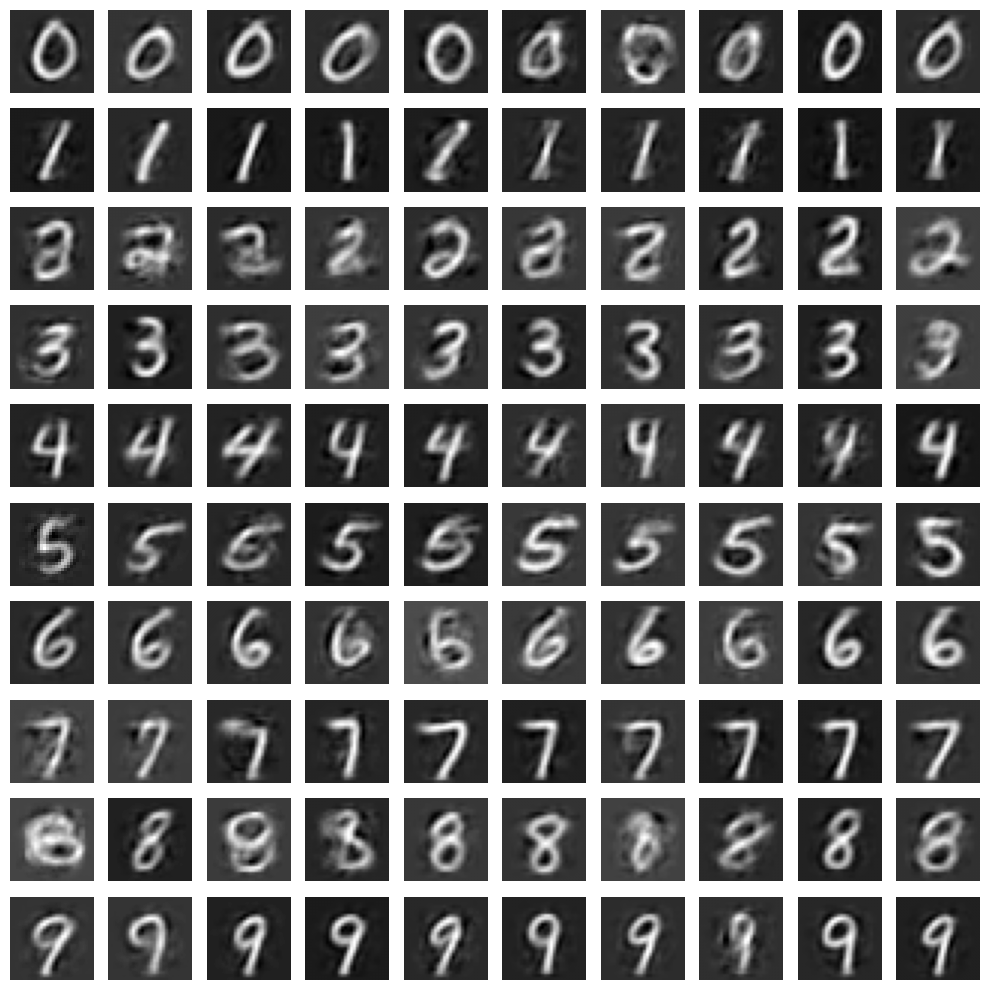

In [9]:
import matplotlib.pyplot as plt
import torch

fig, axes = plt.subplots(
    nrows=10,
    ncols=10,
    figsize=(10, 10),
    tight_layout=True
)

for digit in range(10):
    labels = torch.full(
        (10,),
        fill_value=digit,
        dtype=torch.long,
        device=model.device
    )
    
    imgs = model.generate_images(labels, style_z=None, prior_std=0.5)
    for col in range(10):
        ax = axes[digit, col]
        img = imgs[col].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')

fig.savefig(f'{RESULT_FOLDER}/digits_0_to_9', dpi=300, bbox_inches='tight')
plt.show()


Genrate same digit with different style representations to investigate the correlation of the latent vector with image style

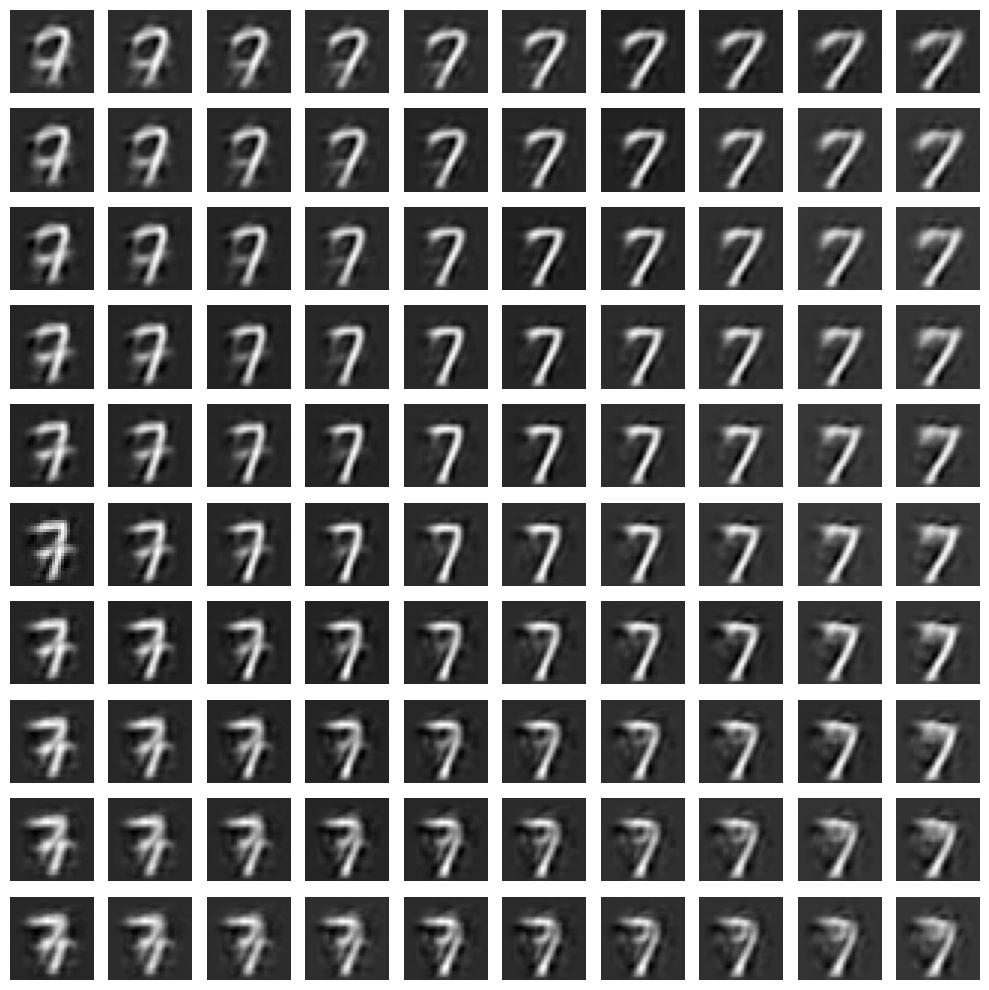

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt

digit = 7  
n = 10 
grid_range = 2.0

style_grid_x = np.linspace(-grid_range, grid_range, n)
style_grid_y = np.linspace(-grid_range, grid_range, n)

fig, axes = plt.subplots(n, n, figsize=(10, 10), tight_layout=True)

style_z = torch.zeros((n * n, model.options.latent_dim_style), device=model.device)
for i, sx in enumerate(style_grid_x):
    for j, sy in enumerate(style_grid_y):
        idx = i * n + j
        style_z[idx, 0] = sx  # first style dim
        style_z[idx, 1] = sy  # second style dim
        # if more style dims, leave them as 0


labels = torch.full((n * n,), fill_value=digit, dtype=torch.long, device=model.device)
imgs = model.generate_images(labels, style_z=style_z)

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        idx = i * n + j
        img = imgs[idx].squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')


fig.savefig(f'{RESULT_FOLDER}/digit_{digit}_varying_style', dpi=300, bbox_inches='tight')
plt.show()